In [2]:
import os

In [5]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from pytorch_lightning.callbacks import ModelCheckpoint
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.notebook import tqdm

In [48]:
TRAIN_IMG_DIR = '../../imagenet/colorized_imagenet/colorized_imagenet_demo/train'
VAL_IMG_DIR = '../../imagenet/colorized_imagenet/colorized_imagenet_demo/val'
TARGET_DIR = '../../imagenet/colorization_dataset_imagenet/'
TARGET_TRAIN_DIR = os.path.join(TARGET_DIR, 'train')
TARGET_VAL_DIR = os.path.join(TARGET_DIR, 'val')
CLASSES_PATH = '../data/used_ab_pairs.txt'
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

In [34]:
def get_nearest_bin(ab, grid_size=10):
    """Get the nearest ab bin to the given ab value.
    ab: Tuple of (a, b) values.
    """
    a, b = ab

    nearest_a = round(a / grid_size) * grid_size
    nearest_b = round(b / grid_size) * grid_size

    return (nearest_a, nearest_b)

In [22]:
used_ab_pairs = []
with open(CLASSES_PATH, 'r') as f:
    for line in f:
        a, b = line.strip().split(',')
        used_ab_pairs.append((int(a), int(b)))

NUM_CLASSES = len(used_ab_pairs)
assert NUM_CLASSES == 256

In [30]:
def one_hot_encode_ab_pairs(ab_tensor, used_ab_pairs, grid_size=10):
    """
    Convert ab values to one-hot encoded tensor based on the closest used_ab_pairs.

    Args:
        ab_tensor (torch.Tensor): Tensor of shape (batch, h, w, 2) containing ab values.
        used_ab_pairs (list): List of used ab pairs.
        grid_size (int): Grid size for quantization.

    Returns:
        torch.Tensor: One-hot encoded tensor of shape (batch, h, w, len(used_ab_pairs)).
    """
    batch, h, w, _ = ab_tensor.shape
    num_classes = len(used_ab_pairs)

    assert ab_tensor.shape[3] == 2, "ab_tensor must have 2 channels."
    assert num_classes == NUM_CLASSES, "Number of classes must match the number of used ab pairs."
    assert h == IMAGE_HEIGHT and w == IMAGE_WIDTH, "Height and width must match the image dimensions."
    
    # Create a tensor to hold the one-hot encoded values
    one_hot_tensor = torch.zeros((batch, h, w, num_classes), dtype=torch.float32)

    # Convert used_ab_pairs to a list of tuples for easy indexing
    used_ab_pairs_list = list(used_ab_pairs)

    # Create a dictionary to map ab pairs to their indices
    ab_pair_to_index = {ab_pair: idx for idx, ab_pair in enumerate(used_ab_pairs_list)}

    # print(ab_tensor.shape)

    # Iterate over each pixel in the batch
    for b in range(batch):
        for i in range(h):
            for j in range(w):
                ab_value = ab_tensor[b, i, j].numpy()
                nearest_bin = get_nearest_bin(ab_value, grid_size)
                if nearest_bin in ab_pair_to_index:
                    one_hot_tensor[b, i, j, ab_pair_to_index[nearest_bin]] = 1.0
                else:
                    raise ValueError(f"Nearest bin not found: {nearest_bin}")

    assert torch.all(one_hot_tensor.sum(dim=-1) == 1.0), "One-hot tensor is not correctly encoded."
    
    return one_hot_tensor


In [31]:
class AutoColorizationDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_files = sorted(os.listdir(img_dir))
        self.label_files = sorted(os.listdir(label_dir))
        self.num_classes = len(used_ab_pairs)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        
        label = Image.open(label_path).convert('RGB') # to ensure RGB format
        label_np = np.array(label)
        label_lab = cv2.cvtColor(label_np, cv2.COLOR_RGB2LAB)
        l = label_lab[:, :, 0]  # Lightness channel
        ab = label_lab[:, :, 1:]  # AB channels

        ab = torch.tensor(ab, dtype=torch.float32)#.permute(2, 0, 1)
        # print(ab.shape)

        ab_onehot = one_hot_encode_ab_pairs(ab[None, :, :, :], used_ab_pairs).squeeze(0)

        l_tensor = torch.tensor(l, dtype=torch.float32).unsqueeze(0)  # Shape: [1, H, W]
        # ab_tensor = torch.tensor(ab, dtype=torch.float32).permute(2, 0, 1)  # Shape: [2, H, W]

        ab_onehot_tensor = ab_onehot.permute(2, 0, 1) # Shape [NUM_CLASSES, H, W]

        assert ab_onehot_tensor.shape == (self.num_classes, IMAGE_HEIGHT, IMAGE_WIDTH), "One-hot tensor shape is incorrect."

        onehot_index = ab_onehot_tensor.argmax(dim=0)
        
        input_l = l_tensor
        target = onehot_index

        return input_l, target

In [32]:
source_train_dataset = AutoColorizationDataset(TRAIN_IMG_DIR + '/img', TRAIN_IMG_DIR + '/label')
source_val_dataset = AutoColorizationDataset(VAL_IMG_DIR + '/img', VAL_IMG_DIR + '/label')

In [52]:
def combine_l_ab(l : torch.Tensor, ab : torch.Tensor) -> np.ndarray:
    """Returns RGB image from LAB lightness and AB channels."""

    # if not batched then add batch dimension
    # while l.ndim < 4:
    #     l = l.unsqueeze(0)
    # while ab.ndim < 4:
    #     ab = ab.unsqueeze(0)

    # ab is index for NUM_CLASSES bins
    # print(l.shape)
    # print(ab.shape)

    lab_image_tensor = torch.cat((l, ab), dim=1)  # Shape: [1, 3, H, W]

    lab_image_np = lab_image_tensor.squeeze(0).numpy().transpose(1, 2, 0)

    assert lab_image_np.shape == (IMAGE_HEIGHT, IMAGE_WIDTH, 3), f"LAB image shape {lab_image_np.shape} is incorrect"

    # **Fix LAB ranges for OpenCV**
    # Ensure L is in [0, 255]
    lab_image_np[:, :, 0] = np.clip(lab_image_np[:, :, 0], 0, 255)

    # Ensure A and B are centered around 128 and within [0, 255]
    lab_image_np[:, :, 1:] = np.clip(lab_image_np[:, :, 1:], 0, 255)

    # Convert LAB back to RGB
    rgb_image = cv2.cvtColor(lab_image_np.astype(np.uint8), cv2.COLOR_LAB2RGB)

    return rgb_image

In [38]:
def convert_index_tensor_to_ab_tensor(index_tensor : torch.Tensor, used_ab_pairs) -> torch.Tensor:
    assert index_tensor.ndim == 2, "Index tensor must be 2D."
    ab = torch.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, 2), dtype=torch.float32)
    for i in range(IMAGE_HEIGHT):
        for j in range(IMAGE_WIDTH):
            ab[0, i, j] = torch.tensor(used_ab_pairs[index_tensor[i, j]], dtype=torch.float32)
    assert ab.shape == (1, IMAGE_HEIGHT, IMAGE_WIDTH, 2), "AB shape is incorrect."
    return ab

In [40]:
def combine_l_index_ab(l : torch.Tensor, ab_index : torch.Tensor, used_ab_pairs) -> np.ndarray:

    assert ab_index.shape == (IMAGE_HEIGHT, IMAGE_WIDTH), "AB shape is incorrect."

    ab = convert_index_tensor_to_ab_tensor(ab_index, used_ab_pairs)

    ab = ab.permute(0, 3, 1, 2)

    assert ab.shape == (1, 2, IMAGE_HEIGHT, IMAGE_WIDTH), "AB shape is incorrect."
    
    if l.ndim == 3:
        l = l.unsqueeze(0)

    assert ab.shape == (1, 2, IMAGE_HEIGHT, IMAGE_WIDTH), "AB shape is incorrect."
    assert l.shape == (1, 1, IMAGE_HEIGHT, IMAGE_WIDTH), "L shape is incorrect."
    return combine_l_ab(l, ab)

In [41]:
def to_image(tensor):
    return tensor.squeeze(0).squeeze(0).cpu().numpy() if tensor.shape[0] == 1 else tensor.permute(1, 2, 0).cpu().numpy()

torch.Size([1, 256, 256]) torch.Size([256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])


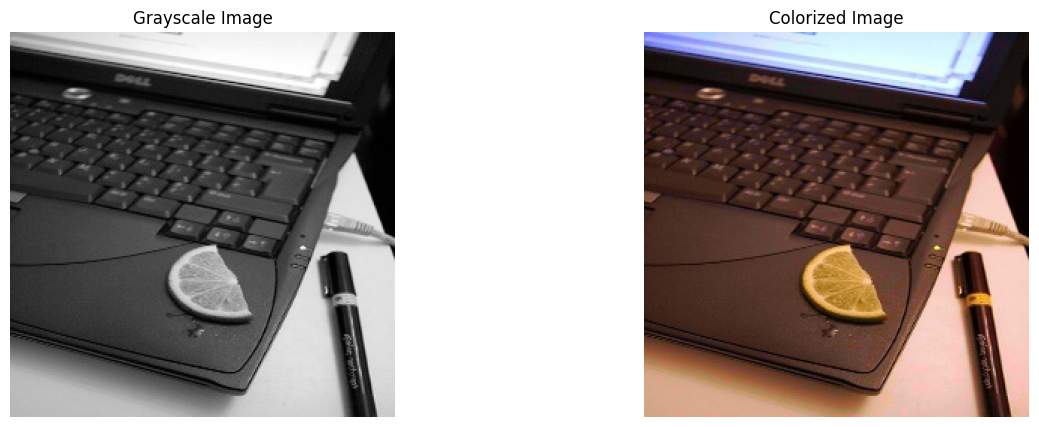

In [ ]:
for X, y in source_train_dataset:
    # print(X.shape, y.shape)
    grayscale_image = to_image(X)
    label_image = combine_l_index_ab(X, y, used_ab_pairs)

    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(grayscale_image, cmap='gray')
    # plt.title('Grayscale Image')
    # plt.axis('off')

    # plt.subplot(1, 2, 2)
    # plt.imshow(label_image)
    # plt.title('Colorized Image')
    # plt.axis('off')
    
    # plt.show()
    break

In [65]:
start_index = 569
index = 0
for X, y in tqdm(source_train_dataset):
    if index < start_index:
        index += 1
        continue
    # print(X.shape, y.shape)
    try:
        grayscale_image = to_image(X)
        label_image = combine_l_index_ab(X, y, used_ab_pairs)
    except:
        print(f"Error in image {index}")
        continue

    # save X, y in TARGET_IMG_DIR, TARGET_LABEL_DIR, use zero padding in filenames 000000.pt, use torch.save

    torch.save(X, os.path.join(TARGET_TRAIN_DIR, 'img', f"{index:06d}.pt"))
    torch.save(y, os.path.join(TARGET_TRAIN_DIR, 'label', f"{index:06d}.pt"))

    index += 1

  0%|          | 0/45009 [00:00<?, ?it/s]

ValueError: Nearest bin not found: (40, 200)

In [61]:
index

566

In [62]:
index = 0
for X, y in tqdm(source_val_dataset):
    try:
        grayscale_image = to_image(X)
        label_image = combine_l_index_ab(X, y, used_ab_pairs)
    except:
        print(f"Error in image {index}")
        continue
    # save X, y in TARGET_IMG_DIR, TARGET_LABEL_DIR, use zero padding in filenames 000000.pt, use torch.save

    torch.save(X, os.path.join(TARGET_VAL_DIR, 'img', f"{index:06d}.pt"))
    torch.save(y, os.path.join(TARGET_VAL_DIR, 'label', f"{index:06d}.pt"))

    index += 1

  0%|          | 0/4991 [00:00<?, ?it/s]

KeyboardInterrupt: 